# import library

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import random
import torch
import torch.backends.cudnn  as cudnn
"""
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
#import talib
from fracdiff.sklearn import Fracdiff, FracdiffStat
import yfinance as yf
from advanced_ta import LorentzianClassification
"""

'\nimport ta\nfrom ta import add_all_ta_features\nfrom ta.utils import dropna\nfrom statsmodels.tsa.stattools import adfuller\n#import talib\nfrom fracdiff.sklearn import Fracdiff, FracdiffStat\nimport yfinance as yf\nfrom advanced_ta import LorentzianClassification\n'

# Set seed

In [128]:


seed = 42
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)



# Download Input

In [129]:
"""ticker = 'AAPL'
aapl = pd.read_csv('aapl2016-2024.csv',index_col='Date', parse_dates=True)"""

"ticker = 'AAPL'\naapl = pd.read_csv('aapl2016-2024.csv',index_col='Date', parse_dates=True)"

In [130]:
import os
import glob
import pandas as pd

# Define the path to the main folder
main_folder_path = 'AAPL_data'
ticker = "AAPL"
# Use glob to get a list of CSV files from all subfolders
csv_files = glob.glob(os.path.join(main_folder_path, '*', '*.csv'))

# List to hold all the DataFrames
all_stock_data_list = []
label_list = []
all_pct_list = []
# Loop over the list of csv files
for file in csv_files:
    # Read the csv file and append it to the list of DataFrames
    df = pd.read_csv(file,index_col='Date', parse_dates=True)
    df['pct_change'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    label_list.append(df['Label'])
    all_pct_list.append(df['pct_change'].tolist())
    df.drop(columns=['pct_change'], inplace=True)
    all_stock_data_list.append(df)
    
# Optionally combine all DataFrames into a single one if they have the same structure
# combined_df = pd.concat(df_list, ignore_index=True)

In [131]:
df.dropna(inplace=True)

In [132]:
len(all_pct_list[0])

2514

In [133]:
float(csv_files[1].split('_')[3][:4])

0.05

# Data Preprocessing

### add technical indicators

In [134]:
stock = all_stock_data_list[0]
labels = label_list[0]
close_pct_change = all_pct_list[0]
all_date = stock.index
stock.dropna(inplace=True)

### Fractional Differenciation

### Min Max Scaling

In [135]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(stock)

In [136]:
all_date

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=2514, freq=None)

# Create Sequence and Dataloader for K Fold LSTM

In [137]:

all_date = stock.index
validationLength = 100
# Function to create sequences
def create_sequences(data, labels, pct_change, all_date, seq_length):
    xs = []
    ys = []
    pct_list = []
    date_list = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        pct = pct_change[i+seq_length]
        date = all_date[i+seq_length]
        xs.append(x)
        ys.append(y)
        pct_list.append(pct)
        date_list.append(date)
    return np.array(xs), np.array(ys), np.array(pct_list), np.array(date_list)


#X_all, y_all, pct_list, date_list = create_sequences(data_scaled, labels, close_pct_change, all_date, sequence_length)

In [138]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold
def  kfold_data(X_all, y_all, pct_list, date_list, n_splits=10):
    validationLength = 100
    # Create the KFold object with the specified number of splits
    kf = KFold(n_splits=n_splits)

    # Initialize lists to hold the fold data
    X_train_folds = []
    y_train_folds = []
    X_val_folds = []
    y_val_folds = []
    pct_train_folds = []
    pct_val_folds = []
    date_val_fold = []
    # Generate the indices for the K-Fold
    kf_indices = kf.split(X_all[0:len(X_all) - validationLength])

    # Loop through each fold
    for train_index, val_index in kf_indices:
        # Generate the training and validation sets for X and y
        X_train, X_val = X_all[train_index], X_all[val_index]
        y_train, y_val = y_all[train_index], y_all[val_index]
        pct_train, pct_val = pct_list[train_index], pct_list[val_index]
        date_val = date_list[val_index]
        # Append the data for this fold to the lists
        X_train_folds.append(X_train)
        y_train_folds.append(y_train)
        X_val_folds.append(X_val)
        y_val_folds.append(y_val)
        pct_train_folds.append(pct_train)
        pct_val_folds.append(pct_val)
        date_val_fold.append(date_val)

    return X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold

#X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold = k_fold_data(X_all, y_all, pct_list, date_list)
# Now you have your folds in the _folds lists, and can train and validate your models on them.

In [139]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

In [140]:
def createDataLoader(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Create the dataset
    traindataset = StockDataset(X_train_tensor, y_train_tensor)

    # Create the DataLoader
    trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create the dataset
    valdataset = StockDataset(X_val_tensor, y_val_tensor)

    # Create the DataLoader
    valLoader = DataLoader(valdataset, batch_size=32, shuffle=False)

  
    return trainLoader, valLoader

# Defining Model

In [141]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, dropout_prob = 0.5):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers,dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)
"""
num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers
"""


'\nnum_features = X_train_folds[0].shape[-1]  # Number of features\nhidden_units = 250  # Number of hidden units\nnum_layers = 2  # Number of LSTM layers\n'

# Model Training and Evaluation

In [142]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.metrics import accuracy_score

# Assuming 'StockPredictor' is a class derived from nn.Module
# and 'trainLoader' is an instance of DataLoader

def train_model(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int,
    num_features: int,
    hidden_units: int,
    num_layers: int) -> Tuple[nn.Module, list]:
    """
    Train the model and return the model with the minimum loss.

    Parameters:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - num_epochs: Number of epochs to train.
    
    Returns:
    - min_loss_model: The model with the minimum loss achieved during training.
    - epoch_loss_history: List of loss values recorded at the end of each epoch.
    """
    min_loss = float('inf')
    minValLoss = float('inf')
    min_loss_model = StockPredictor(num_features, hidden_units, num_layers)  # Assumes these are attributes of your model
    minValLossModel = StockPredictor(num_features, hidden_units, num_layers)
    maxAccuracyModel = StockPredictor(num_features, hidden_units, num_layers)
    train_epoch_loss_history = []
    test_epoch_loss_history = []
    maxaccuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            predictions = model(features).squeeze(1)
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_loss_history.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            min_loss_model.load_state_dict(model.state_dict())  # Copy model weights
        
        model.eval()
        valPredictions = []
        actuals = []
        validation_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                # Forward pass to get output/prediction
                outputs = model(features).squeeze()
                val_loss = criterion(outputs, labels)
                validation_loss += val_loss.item()
                
                # Since we're using sigmoid, we will round the outputs to get the binary class
                predicted_classes = torch.round(outputs)
                
                if predicted_classes.ndim == 0:
                    predicted_classes = predicted_classes.unsqueeze(0)

                # Store valPredictions and actual labels
                valPredictions.extend(predicted_classes.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
        accuracy = accuracy_score(np.array(actuals), np.array(valPredictions))
        validation_loss /= len(val_loader)
        test_epoch_loss_history.append(validation_loss)
        if minValLoss >= validation_loss:
            minValLoss = validation_loss
            minValLossModel.load_state_dict(model.state_dict())
            maxaccuracy = accuracy
        """if maxaccuracy <= accuracy:
            maxAccuracyModel.load_state_dict(model.state_dict())"""
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}, accuracy: {accuracy:.4f} maxaccuracy: {maxaccuracy:.4f}  Validation Loss: {validation_loss:.4f}, Minimum Validation Loss: {minValLoss:.4f}')

    return model, train_epoch_loss_history,test_epoch_loss_history, maxaccuracy, minValLoss



# minLossModel, loss_history = train_model(model, trainLoader, criterion, optimizer, num_epochs)

In [143]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader) -> Tuple[list, list, list]:
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained neural network model for evaluation.
    - test_loader: DataLoader for the test data.

    Returns:
    - probabilities: List of raw output probabilities from the model.
    - predictions: List of predicted classes based on the output probabilities.
    - actuals: List of actual labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    probabilities = []
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track the gradients
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass to get output/prediction
            outputs = model(features).squeeze()

            # Since we're using sigmoid, we will round the outputs to get the binary class
            predicted_classes = torch.round(outputs)
            
            # In case of single-element batches, add an extra dimension
            if predicted_classes.ndim == 0:
                predicted_classes = predicted_classes.unsqueeze(0)

            # Store predictions and actual labels
            probabilities.extend(outputs.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return probabilities, predictions, actuals

# Usage example
# Assuming 'minLossModel' is the trained model and 'testLoader' is defined elsewhere

# probabilities, predictions, actuals = evaluate_model(minLossModel, testLoader)

'AAPL_data/result/AAPL_0.00_result.csv'

In [157]:
import os
result_path = main_folder_path + '/result'
if not os.path.exists(result_path):
    os.makedirs(result_path)


In [148]:
def downside_deviation(returns, threshold=0):
    # Calculate the difference between the returns and the threshold
    downside_diff = np.minimum(returns - threshold, 0)
    # Square the differences, sum them, divide by the number of observations,
    # and then take the square root
    return np.sqrt(np.mean(downside_diff ** 2))

def cum_return(probabilities, pct_change, dates, ticker, threshold=0, plot_graph=0, verbose=0):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()
    
    # Calculate downside deviations for buy and hold and prediction
    buy_and_hold_downside_dev = downside_deviation(pct_change, threshold)
    prediction_downside_dev = downside_deviation(predictions_array * pct_change, threshold)
    if verbose:
        print(f"Buy & Hold Downside Deviation: {buy_and_hold_downside_dev}")
        print(f"Prediction Downside Deviation: {prediction_downside_dev}")

        print(f'Cumulative return of buy and hold: {buy_and_hold[-1]}')
        print(f'Cumulative return of Prediction: {prediction[-1]}')
        # Create the plot for cumulative returns
    if plot_graph == 1:
        plt.figure(figsize=(10, 5))
        plt.plot(dates, buy_and_hold, label='Buy & Hold')
        plt.plot(dates, prediction, label='Prediction')
        
        # Setting the x-axis as date
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        
        # Labels and legend
        plt.ylabel('Cumulative Returns')
        plt.legend(loc='lower right')
        
        # Title
        plt.title(f"{ticker} Cumulative Return Comparison")
        
        # Show the plot for cumulative returns
        plt.tight_layout()
        plt.show()

    return prediction_downside_dev, prediction[-1]


In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def evaluation(predictions, probabilities, actuals, verbose=0, threshold = 0.5):
    probabilities_array = np.array(probabilities)
    predictions_array = (probabilities_array >= threshold).astype(int)
    actuals_array = np.array(actuals)

    # Calculate various classification metrics
    accuracy = accuracy_score(actuals_array, predictions_array)
    precision = precision_score(actuals_array, predictions_array)
    recall = recall_score(actuals_array, predictions_array)
    f1 = f1_score(actuals_array, predictions_array)
    conf_matrix = confusion_matrix(actuals_array, predictions_array)
    auc_score = roc_auc_score(actuals_array, probabilities_array)

    # Print out the metrics
    if verbose:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'AUC Score: {auc_score:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

In [154]:
from tqdm import tqdm
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers

num_epochs = 5

def hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length,stock=stock):
    # Define the model
    
    dates = stock.index[sequence_length:-validationLength]
    X_all, y_all, pct_list, date_list = create_sequences(data_scaled, labels, close_pct_change, all_date, sequence_length)
    X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold = kfold_data(X_all, y_all, pct_list, date_list)
    num_features = X_train_folds[0].shape[-1]  # Number of features
    probabilities, predictions, actuals, train_loss_history, test_loss_history , all_pct_change, downside_deviation_list, cumulative_return_list= [], [] ,[], [], [],[],[],[]
    for i in range(len(X_train_folds)):
        print(f'round {i+1}')
        trainLoader, valLoader= createDataLoader(X_train_folds[i],y_train_folds[i],X_val_folds[i],y_val_folds[i])
        accuracy, validationLoss,train_loss_history_tmp, test_loss_history_tmp = 0,float('inf'), [],[]
        
        model = StockPredictor(num_features, hidden_units, num_layers,dropout_prob=0.05)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        model, train_loss_history_tmp, test_loss_history_tmp,accuracy, validationLoss = train_model(model, trainLoader,valLoader, criterion, optimizer, num_epochs,num_features, hidden_units, num_layers)

        probabilities_tmp, predictions_tmp, actuals_tmp = evaluate_model(model, valLoader)
        dd, cr = cum_return(probabilities_tmp, pct_val_folds[i], date_val_fold[i],ticker)
        probabilities.extend(probabilities_tmp)
        predictions.extend(predictions_tmp)
        actuals.extend(actuals_tmp)
        all_pct_change.extend(pct_val_folds[i])
        train_loss_history.append(train_loss_history_tmp)
        test_loss_history.append(test_loss_history_tmp)
        downside_deviation_list.append(dd)
        cumulative_return_list.append(cr)
        #print('threshold = 0.5')
        evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp)
        


    
    overall_dd, overall_cr = cum_return(probabilities,  close_pct_change[sequence_length:-validationLength], dates, ticker, plot_graph=1)
    print('overall results:')
    evaluation(predictions,probabilities,actuals)
    downside_deviation_list = downside_deviation_list
    std_downside_deviation = np.std(downside_deviation_list)
    print(np.std(downside_deviation_list))
    return downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation

#downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation = hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length=10)

    

  0%|          | 0/42 [00:00<?, ?it/s]C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Training with 100 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1
Epoch [10/10], Loss: 0.6913, minimum Loss: 0.6913, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6923, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6891, minimum Loss: 0.6891, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7036, Minimum Validation Loss: 0.6947
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6920, minimum Loss: 0.6918, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6925, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6949, minimum Loss: 0.6949, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6881, Minimum Validation Loss: 0.6881
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6929, minimum Loss: 0.6922, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6916
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6921, minimum Loss: 0.6921, accuracy: 0.5356 ma

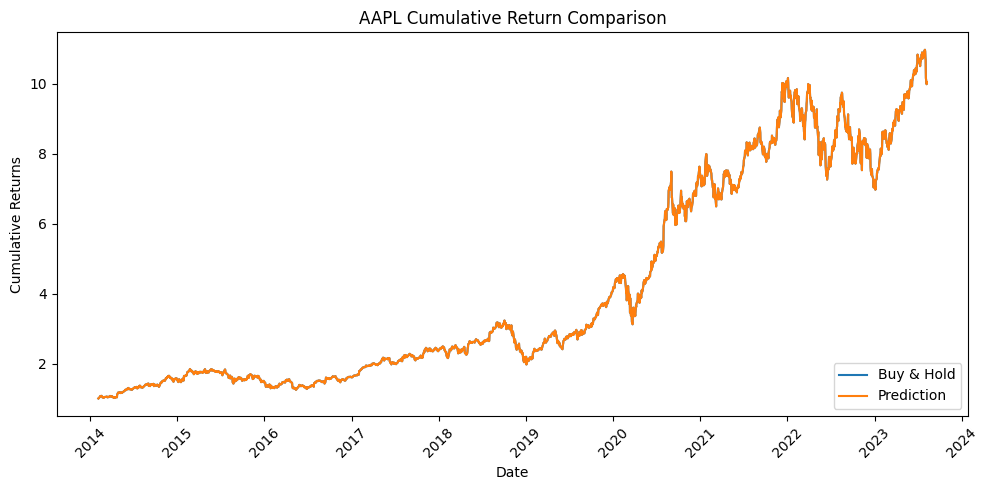

overall results:
0.0032891065624615864
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013551516474829191, 0.012387297334393798]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1202273176906332, 1.073240639657769]
Overall downside deviation: 0.012255580549066048
Overall cumulative return: 10.038083964811198


Training with 500 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6853, minimum Loss: 0.6829, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6927, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6804, minimum Loss: 0.6804, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7039, Minimum Validation Loss: 0.6995
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6828, minimum Loss: 0.6828, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6932, Minimum Validation Loss: 0.6920
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6911, minimum Loss: 0.6911, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6878, Minimum Validation Loss: 0.6878
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6900, minimum Loss: 0.6900, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6911, minimum Loss: 0.6911, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6892, Minimum Validation Loss: 0.6892
thre

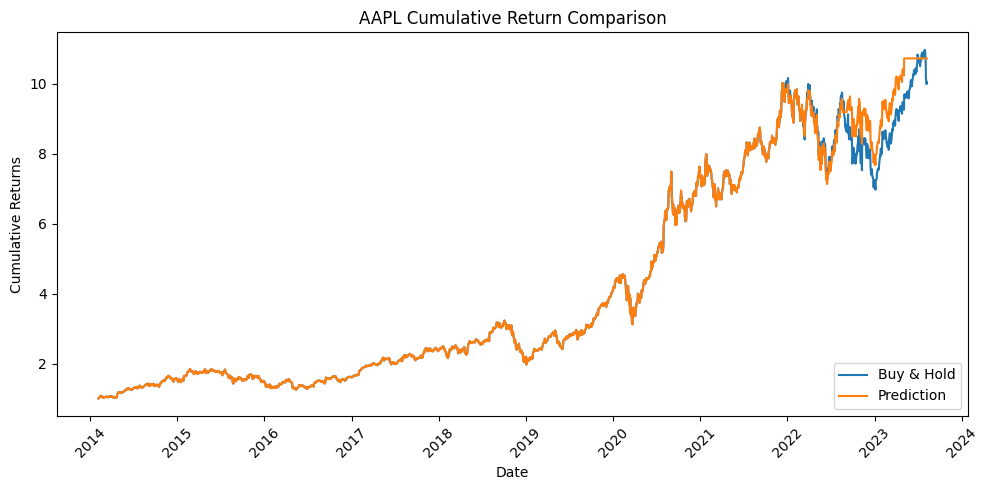

  2%|▏         | 1/42 [01:01<42:05, 61.61s/it]

overall results:
0.0032968902513456507
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013469364535770752, 0.010595465537812352]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.100596770349696, 1.1667292666790727]
Overall downside deviation: 0.012077516298000796
Overall cumulative return: 10.721261319260778




Training with 100 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6908, minimum Loss: 0.6908, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6925, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6869, minimum Loss: 0.6869, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7034, Minimum Validation Loss: 0.6978
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6929, minimum Loss: 0.6929, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6925, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6914, minimum Loss: 0.6914, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6879, Minimum Validation Loss: 0.6879
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6925, minimum Loss: 0.6925, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6918, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6922, minimum Loss: 0.6922, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6895, Minimum Validation Loss: 0.6895
thre

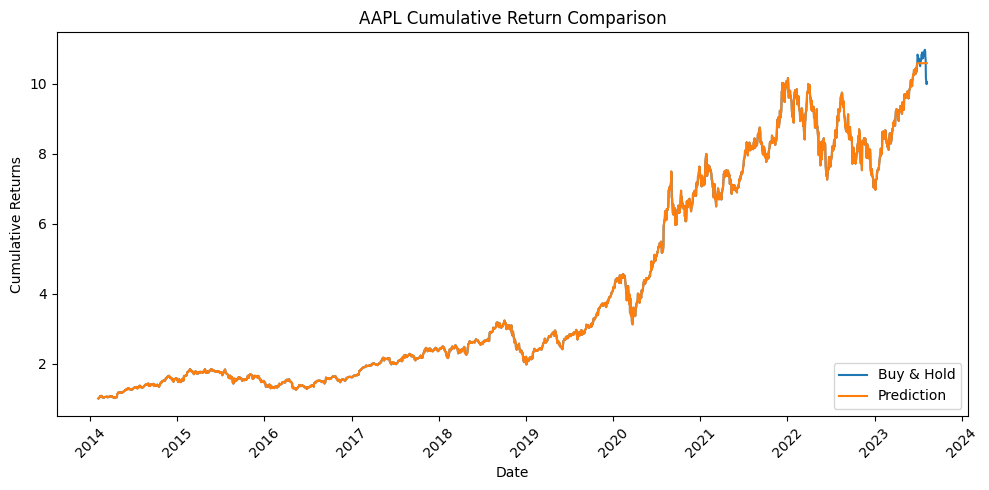

overall results:
0.003283530128408206
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013551516474829191, 0.011806917077163807]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1202273176906332, 1.1316778948208281]
Overall downside deviation: 0.01219825464273925
Overall cumulative return: 10.584651111380435


Training with 500 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6837, minimum Loss: 0.6828, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6927, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6804, minimum Loss: 0.6804, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7040, Minimum Validation Loss: 0.6987
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6848, minimum Loss: 0.6848, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6932, Minimum Validation Loss: 0.6920
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6908, minimum Loss: 0.6908, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6878, Minimum Validation Loss: 0.6878
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6905, minimum Loss: 0.6905, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6900, minimum Loss: 0.6900, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6892, Minimum Validation Loss: 0.6892
thre

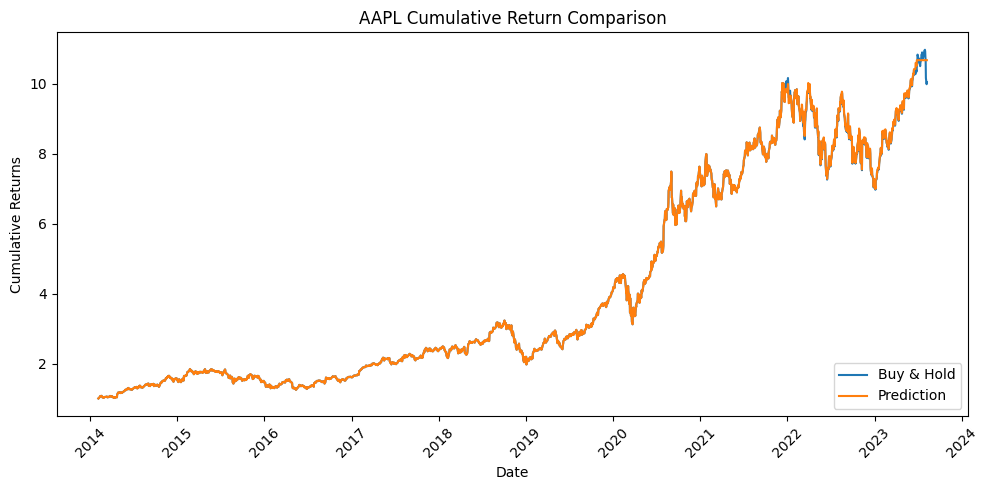

  5%|▍         | 2/42 [02:04<41:28, 62.22s/it]

overall results:
0.003279096695947711
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013469364535770752, 0.011794600355013816]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1234898376203701, 1.1375535369959744]
Overall downside deviation: 0.01218797705470571
Overall cumulative return: 10.67059284799687




Training with 100 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6914, minimum Loss: 0.6914, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6924, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6876, minimum Loss: 0.6876, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7031, Minimum Validation Loss: 0.6967
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6926, minimum Loss: 0.6926, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6925, Minimum Validation Loss: 0.6920
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6931, minimum Loss: 0.6931, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6880, Minimum Validation Loss: 0.6880
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6922, minimum Loss: 0.6922, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6918, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6938, minimum Loss: 0.6933, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6895, Minimum Validation Loss: 0.6895
thre

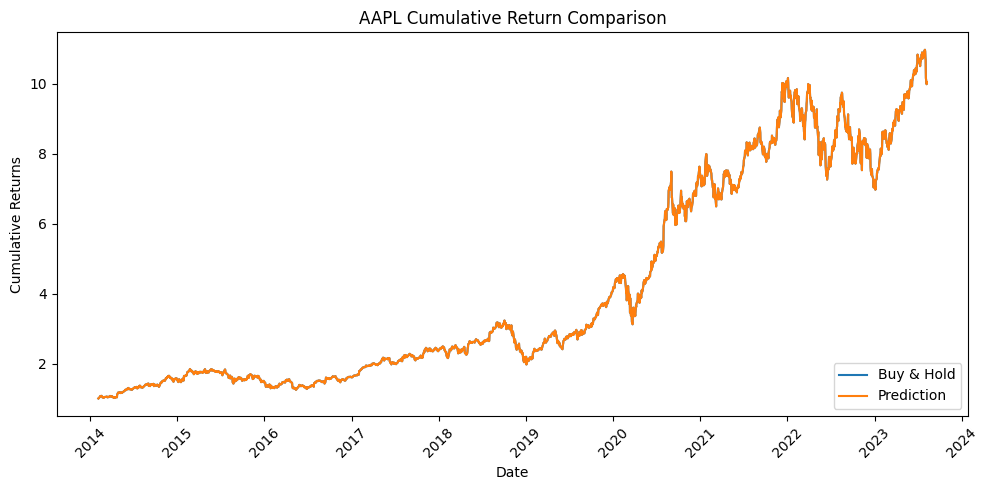

overall results:
0.0032891065624615864
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013551516474829191, 0.012387297334393798]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1202273176906332, 1.073240639657769]
Overall downside deviation: 0.012255580549066048
Overall cumulative return: 10.038083964811198


Training with 500 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6832, minimum Loss: 0.6832, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6928, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6797, minimum Loss: 0.6797, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7037, Minimum Validation Loss: 0.6996
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6829, minimum Loss: 0.6829, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6932, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6904, minimum Loss: 0.6904, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6878, Minimum Validation Loss: 0.6878
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6896, minimum Loss: 0.6896, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6916
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6926, minimum Loss: 0.6925, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6892, Minimum Validation Loss: 0.6892
thre

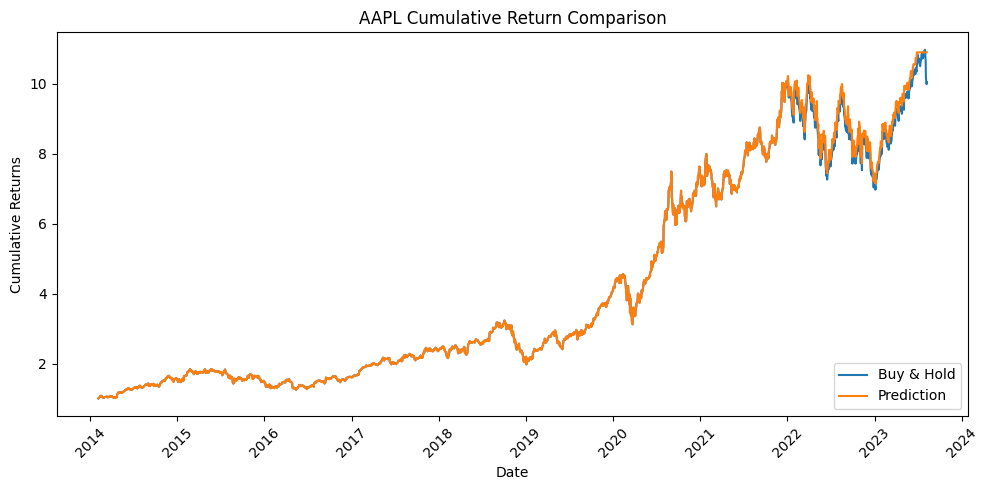

  7%|▋         | 3/42 [03:07<40:49, 62.80s/it]

overall results:
0.003280192001497928
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013490348576835908, 0.011783266399128585]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1485806959161, 1.1359322097549498]
Overall downside deviation: 0.012189199487046642
Overall cumulative return: 10.893350629068607




Training with 100 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6908, minimum Loss: 0.6908, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6924, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6864, minimum Loss: 0.6864, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7038, Minimum Validation Loss: 0.6960
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6903, minimum Loss: 0.6903, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6926, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6937, minimum Loss: 0.6922, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6879, Minimum Validation Loss: 0.6879
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6932, minimum Loss: 0.6931, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6928, minimum Loss: 0.6928, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6895, Minimum Validation Loss: 0.6895
thre

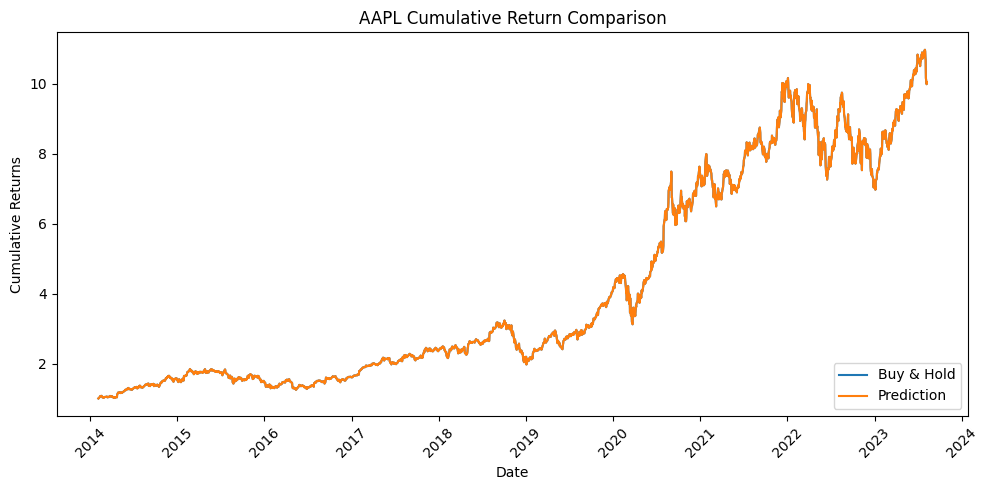

overall results:
0.0032891065624615864
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.013551516474829191, 0.012387297334393798]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.1202273176906332, 1.073240639657769]
Overall downside deviation: 0.012255580549066048
Overall cumulative return: 10.038083964811198


Training with 500 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6829, minimum Loss: 0.6829, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6928, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6806, minimum Loss: 0.6806, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7038, Minimum Validation Loss: 0.6992
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6834, minimum Loss: 0.6834, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6931, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6899, minimum Loss: 0.6899, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6878, Minimum Validation Loss: 0.6878
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6895, minimum Loss: 0.6895, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6917
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6906, minimum Loss: 0.6906, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6892, Minimum Validation Loss: 0.6892
thre

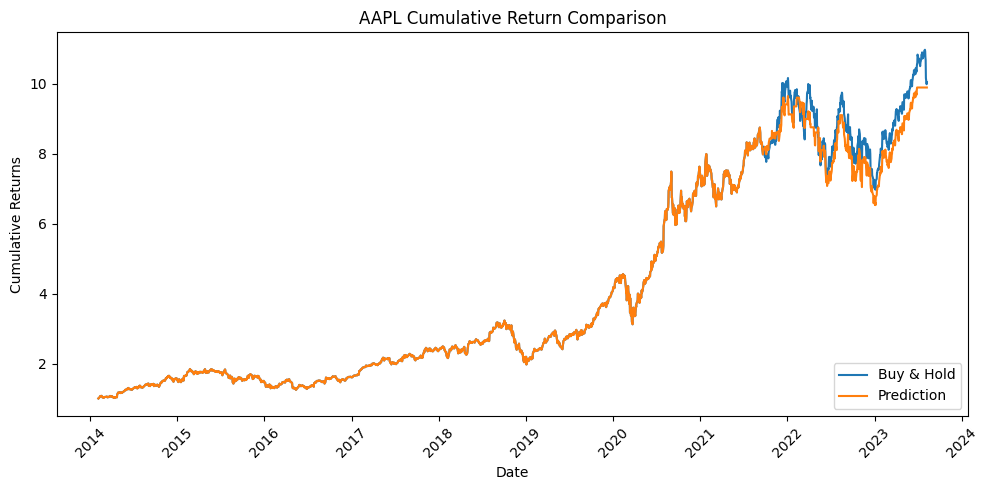

 10%|▉         | 4/42 [04:09<39:31, 62.41s/it]

overall results:
0.0032284674776888464
Downside deviation list: [0.0077747006084062115, 0.011679815810323721, 0.010679148955587008, 0.00646979659537216, 0.010715516324257643, 0.013988994171036538, 0.019074448689687027, 0.011782452976411855, 0.011441540598130616, 0.011806917077163807]
Cumulative return list: [1.4909178362876383, 1.0179741450517734, 1.047912444241534, 1.5354103677013422, 1.1522061534186758, 1.172726861236984, 1.9594771078150475, 1.2913393161595845, 1.0486387419764005, 1.1296484294094509]
Overall downside deviation: 0.011980515545279595
Overall cumulative return: 9.890466062244487




Training with 100 hidden units, 2 layers, 10 epochs. 20 sequence length
round 1


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_23880\3828301436.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Epoch [10/10], Loss: 0.6925, minimum Loss: 0.6925, accuracy: 0.5333 maxaccuracy: 0.5333  Validation Loss: 0.6924, Minimum Validation Loss: 0.6920
threshold = 0.5
round 2
Epoch [10/10], Loss: 0.6890, minimum Loss: 0.6890, accuracy: 0.4792 maxaccuracy: 0.4792  Validation Loss: 0.7030, Minimum Validation Loss: 0.6990
threshold = 0.5
round 3
Epoch [10/10], Loss: 0.6924, minimum Loss: 0.6922, accuracy: 0.5208 maxaccuracy: 0.5208  Validation Loss: 0.6925, Minimum Validation Loss: 0.6921
threshold = 0.5
round 4
Epoch [10/10], Loss: 0.6943, minimum Loss: 0.6943, accuracy: 0.5625 maxaccuracy: 0.5625  Validation Loss: 0.6881, Minimum Validation Loss: 0.6881
threshold = 0.5
round 5
Epoch [10/10], Loss: 0.6943, minimum Loss: 0.6936, accuracy: 0.5272 maxaccuracy: 0.5272  Validation Loss: 0.6917, Minimum Validation Loss: 0.6916
threshold = 0.5
round 6
Epoch [10/10], Loss: 0.6920, minimum Loss: 0.6920, accuracy: 0.5356 maxaccuracy: 0.5356  Validation Loss: 0.6895, Minimum Validation Loss: 0.6895
thre

 10%|▉         | 4/42 [04:23<41:40, 65.81s/it]


KeyboardInterrupt: 

In [166]:
from itertools import product
from sklearn.preprocessing import MinMaxScaler

# Other necessary imports and setup here...

# Define your hyperparameter space
hidden_units_options = [100, 500]
num_layers_options = [ 2]
num_epochs_options = [10]
sequence_length_option = [20]
# Iterate over all combinations
final_result_df_list = []
for i in tqdm(range(len(csv_files))):
    filepath = csv_files[i]
    stock = all_stock_data_list[i]
    labels = label_list[i]
    close_pct_change = all_pct_list[i]
    all_date = stock.index
    results = []
    total_rounds = len(hidden_units_options)* len(num_layers_options) *len(num_epochs_options)* len(sequence_length_option)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(stock)
    for hidden_units, num_layers, num_epochs, sequence_length in tqdm(product(hidden_units_options, num_layers_options, num_epochs_options,sequence_length_option),total=total_rounds):
        print(f'Training with {hidden_units} hidden units, {num_layers} layers, {num_epochs} epochs. {sequence_length} sequence length')
        # Call your hyperParameterTuning function or equivalent training procedure
        downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation = hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length)

        # Here you might want to save the results, or print them out
        # For example:
        print(f'Downside deviation list: {downside_deviation_list}')
        print(f'Cumulative return list: {cumulative_return_list}')
        print(f'Overall downside deviation: {overall_dd}')
        print(f'Overall cumulative return: {overall_cr}')

        print('\n')


        result = {
            'hidden_units': hidden_units,
            'num_layers': num_layers,
            'num_epochs': num_epochs,
            'sequence_length': sequence_length,
            'downside_dev_list': downside_deviation_list,
            'cum_ret_list': cumulative_return_list,
            'std_downside_deviation': std_downside_deviation,
            'overall_downside_deviation': overall_dd,
            'overall_cumulative_return': overall_cr
        }
        results.append(result)
    result_df = pd.DataFrame(results)
    final_result_df_list.append(result_df)
    path = result_path +'/'+ csv_files[i].split('\\')[-1][:-4]+ '_result' + '.csv'
    result_df.to_csv(path)
        



In [153]:
csv_files[0].split('\\')

['AAPL_data', 'without_ta', 'AAPL_0.00.csv']

In [ ]:
'''
from itertools import product

# Other necessary imports and setup here...

# Define your hyperparameter space
hidden_units_options = [100, 300, 500]
num_layers_options = [ 2, 3,4]
num_epochs_options = [5, 10, 15,20]
sequence_length_option = [10,20,30]
# Iterate over all combinations

results = []
total_rounds = len(hidden_units_options)* len(num_layers_options) *len(num_epochs_options)* len(sequence_length_option)
for hidden_units, num_layers, num_epochs, sequence_length in tqdm(product(hidden_units_options, num_layers_options, num_epochs_options,sequence_length_option),total=total_rounds):
    print(f'Training with {hidden_units} hidden units, {num_layers} layers, {num_epochs} epochs. {sequence_length} sequence length')
    # Call your hyperParameterTuning function or equivalent training procedure
    downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation = hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length)

    # Here you might want to save the results, or print them out
    # For example:
    print(f'Downside deviation list: {downside_deviation_list}')
    print(f'Cumulative return list: {cumulative_return_list}')
    print(f'Overall downside deviation: {overall_dd}')
    print(f'Overall cumulative return: {overall_cr}')

    print('\n')


    result = {
        'hidden_units': hidden_units,
        'num_layers': num_layers,
        'num_epochs': num_epochs,
        'sequence_length': sequence_length,
        'downside_dev_list': downside_deviation_list,
        'cum_ret_list': cumulative_return_list,
        'std_downside_deviation': std_downside_deviation,
        'overall_downside_deviation': overall_dd,
        'overall_cumulative_return': overall_cr
    }
    results.append(result)

'''

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,hidden_units,num_layers,num_epochs,downside_dev_list,cum_ret_list,std_downside_deviation,overall_downside_deviation,overall_cumulative_return
0,100,2,10,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.003753,0.011716,8.072500
1,100,2,15,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.080...",0.003627,0.011260,8.107734
2,100,2,20,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.002984,0.010223,9.697677
3,100,2,30,"[0.00838669416617485, 0.006058281013353005, 0....","[1.204307133960275, 1.4568257484563765, 1.1479...",0.003336,0.010733,6.382436
4,100,3,10,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.004052,0.012350,7.203816
...,...,...,...,...,...,...,...,...
95,500,5,30,"[0.00911931323967364, 0.005031979756218735, 0....","[1.1452653413749223, 1.4417738525553818, 1.077...",0.002735,0.009155,4.647988
96,500,6,10,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.004285,0.012417,6.524380
97,500,6,15,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.003841,0.012395,8.453594
98,500,6,20,"[0.00911931323967364, 0.006327840352345503, 0....","[1.1452653413749223, 1.4284027821295535, 1.193...",0.003989,0.011453,7.043237


In [ ]:
results_df.to_csv('aapl_d=0_param_result.csv')

In [ ]:
import pandas as pd

test = pd.read_csv('aapld=0_param_result.csv')

In [ ]:
test

,Unnamed: 0,hidden_units,num_layers,num_epochs,sequence_length,downside_dev_list,cum_ret_list,std_downside_deviation,overall_downside_deviation,overall_cumulative_return
0,0,100,2,5,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
1,1,100,2,5,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
2,2,100,2,5,30,[0.00812884 0.01206419 0.01003592 0.00663609 0...,"[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
3,3,100,2,10,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
4,4,100,2,10,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
...,...,...,...,...,...,...,...,...,...,...
103,103,500,4,15,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
104,104,500,4,15,30,[0.00812884 0.01206419 0.01003592 0.00663609 0...,"[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
105,105,500,4,20,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003222,0.012201,7.533493
106,106,500,4,20,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084


In [ ]:
results_df.columns

Index(['hidden_units', 'num_layers', 'num_epochs', 'sequence_length',
       'downside_dev_list', 'cum_ret_list', 'std_downside_deviation',
       'overall_downside_deviation', 'overall_cumulative_return'],
      dtype='object')

In [ ]:
import ast
test['downside_dev_list'] = test['downside_dev_list'].apply(ast.literal_eval)
test['cum_ret_list'] = test['cum_ret_list'].apply(ast.literal_eval)

Text(0, 0.5, 'Standard Deviation of Downside Deviation')

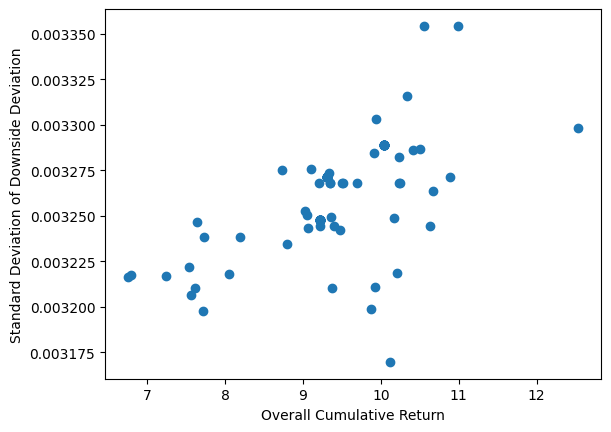

In [91]:
import matplotlib.pyplot as plt
plt.scatter(results_df['overall_cumulative_return'],results_df['std_downside_deviation'])
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')

In [92]:
results_df['overall_cumulative_return'].corr(results_df['std_downside_deviation'])

0.614537120686818

Text(0, 0.5, 'Standard Deviation of Downside Deviation')

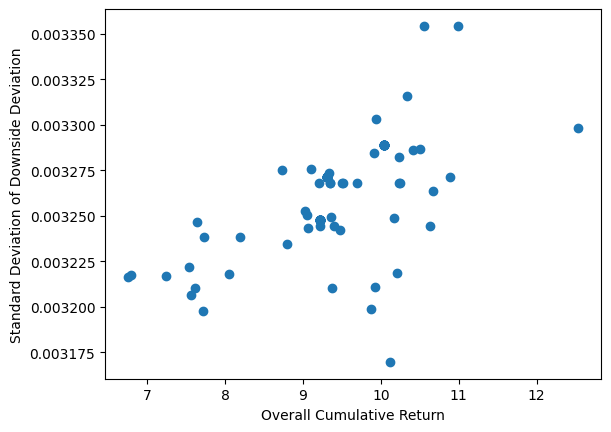

In [93]:
import matplotlib.pyplot as plt
plt.scatter(results_df['overall_cumulative_return'],results_df['std_downside_deviation'])
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')

In [94]:
results_df

,hidden_units,num_layers,num_epochs,sequence_length,downside_dev_list,cum_ret_list,std_downside_deviation,overall_downside_deviation,overall_cumulative_return
0,100,2,5,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
1,100,2,5,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
2,100,2,5,30,"[0.008128840087439651, 0.012064190525036737, 0...","[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
3,100,2,10,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
4,100,2,10,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
...,...,...,...,...,...,...,...,...,...
103,500,4,15,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
104,500,4,15,30,"[0.008128840087439651, 0.012064190525036737, 0...","[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
105,500,4,20,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003222,0.012201,7.533493
106,500,4,20,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084


In [95]:
sorted_df = results_df.sort_values(by='overall_cumulative_return',ascending=False)

In [96]:
sorted_df

,hidden_units,num_layers,num_epochs,sequence_length,downside_dev_list,cum_ret_list,std_downside_deviation,overall_downside_deviation,overall_cumulative_return
76,500,2,10,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003298,0.011822,12.536287
31,100,4,15,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003354,0.011992,10.988154
22,100,3,20,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003271,0.012215,10.889537
10,100,2,20,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003264,0.012106,10.668220
34,100,4,20,20,"[0.0077747006084062115, 0.011679815810323721, ...","[1.4909178362876383, 1.0179741450517734, 1.047...",0.003244,0.012124,10.630628
...,...,...,...,...,...,...,...,...,...
81,500,2,20,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003207,0.012051,7.570476
105,500,4,20,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003222,0.012201,7.533493
90,500,3,15,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003217,0.012139,7.242977
57,300,3,20,10,"[0.008927214109639668, 0.011799746244983313, 0...","[1.415484519964509, 1.018384656299027, 0.99263...",0.003217,0.012119,6.796942


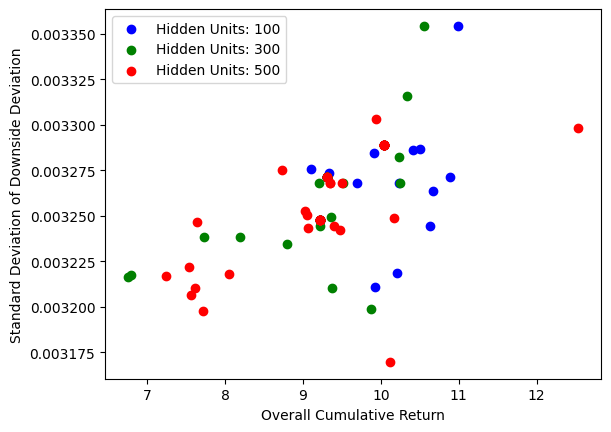

In [97]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each subset of the data with a different color
for i, num_units in enumerate(hidden_units_options):
    subset = results_df[results_df['hidden_units'] == num_units]
    plt.scatter(subset['overall_cumulative_return'], subset['std_downside_deviation'], 
                color=colors[i], label=f'Hidden Units: {num_units}')

# Add labels and legend
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')
plt.legend()

# Show plot
plt.show()

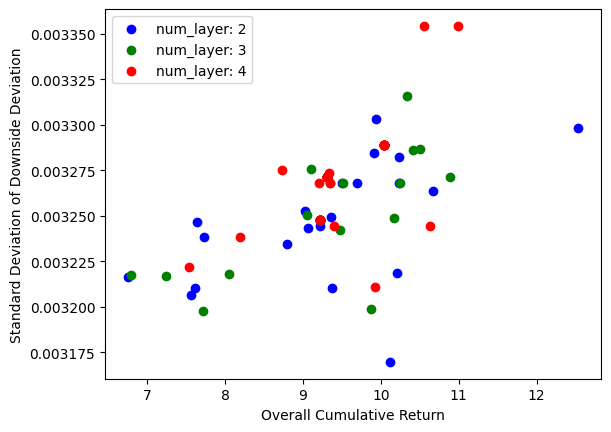

In [98]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each subset of the data with a different color
for i, num_layer in enumerate(num_layers_options):
    subset = results_df[results_df['num_layers'] == num_layer]
    plt.scatter(subset['overall_cumulative_return'], subset['std_downside_deviation'], 
                color=colors[i], label=f'num_layer: {num_layer}')

# Add labels and legend
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')
plt.legend()

# Show plot
plt.show()

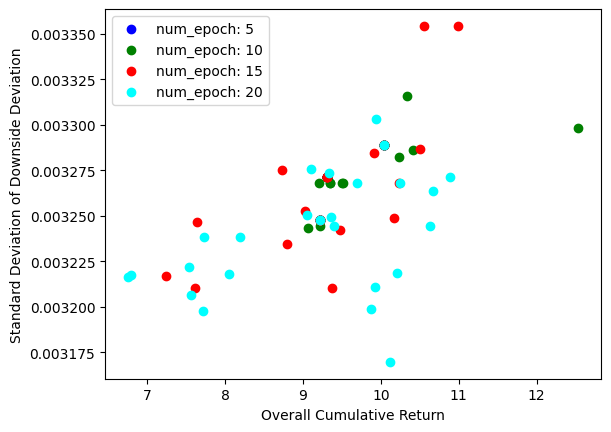

In [99]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each subset of the data with a different color
for i, num_epoch in enumerate(num_epochs_options):
    subset = results_df[results_df['num_epochs'] == num_epoch]
    plt.scatter(subset['overall_cumulative_return'], subset['std_downside_deviation'], 
                color=colors[i], label=f'num_epoch: {num_epoch}')

# Add labels and legend
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')
plt.legend()

# Show plot
plt.show()

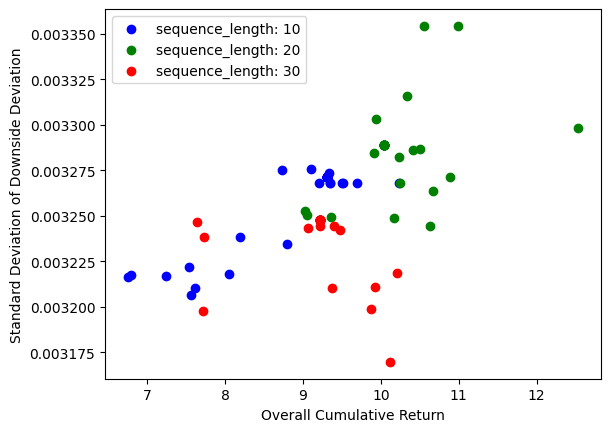

In [101]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each subset of the data with a different color
for i, sequence_length in enumerate(sequence_length_option):
    subset = results_df[results_df['sequence_length'] == sequence_length]
    plt.scatter(subset['overall_cumulative_return'], subset['std_downside_deviation'], 
                color=colors[i], label=f'sequence_length: {sequence_length}')

# Add labels and legend
plt.xlabel('Overall Cumulative Return')
plt.ylabel('Standard Deviation of Downside Deviation')
plt.legend()

# Show plot
plt.show()

In [107]:
path = csv_files[0][:-4] + '_result' + '.csv'
results_df.to_csv(path)

In [108]:
test = pd.read_csv(path)
test

,Unnamed: 0,hidden_units,num_layers,num_epochs,sequence_length,downside_dev_list,cum_ret_list,std_downside_deviation,overall_downside_deviation,overall_cumulative_return
0,0,100,2,5,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
1,1,100,2,5,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
2,2,100,2,5,30,[0.00812884 0.01206419 0.01003592 0.00663609 0...,"[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
3,3,100,2,10,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003271,0.012346,9.311410
4,4,100,2,10,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
...,...,...,...,...,...,...,...,...,...,...
103,103,500,4,15,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
104,104,500,4,15,30,[0.00812884 0.01206419 0.01003592 0.00663609 0...,"[1.5243868764579869, 0.8286795417563677, 1.186...",0.003248,0.012281,9.220682
105,105,500,4,20,10,[0.00892721 0.01179975 0.01088776 0.0064347 0...,"[1.415484519964509, 1.018384656299027, 0.99263...",0.003222,0.012201,7.533493
106,106,500,4,20,20,[0.0077747 0.01167982 0.01067915 0.0064698 0...,"[1.4909178362876383, 1.0179741450517734, 1.047...",0.003289,0.012256,10.038084
